Load packages

In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [ ]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from anndata import AnnData
import skmisc
import regex as re

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp
import functions_plotting as dplt
import functions_for_CAR_annotation as ca
import functions_OVA_annotation as oa

/tmp/ipykernel_2133355/1078855118.py:19: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
#if needed, reload functions
import importlib
importlib.reload(dp)
importlib.reload(dplt)
importlib.reload(ca)

<module 'functions_for_CAR_annotation' from '/home/s377963/car_t_sc/02_code/functions/functions_for_CAR_annotation.py'>

# 1. Workflow with the CARs annotated via bowtie2

In [5]:
#import data

adata_raw = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_raw_demultiplexed.h5ad') 
adata_qc = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc.h5ad')
adata_TIL_only = adata_qc[adata_qc.obs.Location != 'dLN']
adata_pureTC = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc_TIL_only_pure_TC_annotation.h5ad') 
adata_only_pureTC = adata_pureTC[adata_pureTC.obs['is.pure_Tcell'] == 'Pure']
adata_pure_TC_annotated = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc_TIL_only_pure_TC_annotation_non_TC_filtered_TC_subtypes_annotated.h5ad') 
adata_only_annotatedTC = adata_pure_TC_annotated[~adata_pure_TC_annotated.obs['functional.cluster'].isna()]

In [6]:
sum(adata_qc.obs.Location == 'dLN') #why did they kick them out again??? nearly 6K cells

6267

In [7]:
non_annotated = [adata_raw, adata_TIL_only, adata_only_pureTC, adata_only_annotatedTC]

In [8]:

for adata in non_annotated:
    adata.obs.rename(columns={"HTO_classification": "Classification"}, inplace=True) 
    adata.obs.rename(columns={"functional.cluster": "Tcell_subtype"}, inplace=True)
    adata.obs.rename(columns={"pool": "dataset"}, inplace=True)
    rmvd_p = [int(dataset.replace("P", "")) - 1 for dataset in adata.obs['dataset']]
    adata.obs['dataset'] = rmvd_p

/tmp/ipykernel_2133355/1693417359.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['dataset'] = rmvd_p


In [9]:
#import corrected barcodes and process
path = './01_data/processed/cellbarcode_correction/unq_barcodes'
correction_dfs = ca.read_cellbarcode_tsvs(path)

In [10]:
#import CAR counts from VDJ and GEX library and process
path = './01_data/processed/count_cart_receptor'
VDJ_GEX_list = ca.read_and_merge_CAR_annotation(path) #list with dims: list[1][8]
merged = [ca.merge_VDJ_and_GEX(GEX, VDJ) for (GEX, VDJ) in zip(*VDJ_GEX_list)]

In [11]:
#correct the barcodes for the CAR count dataframes
merged_corrected = [ca.merge_CAR_counts_with_corrected_cellbarcodes(brcd, car_counts) for brcd, car_counts in zip(correction_dfs, merged)]

In [12]:
#annotate the CAR counts via the corrected CAR counts to the original anndata object
CAR_genes = ['CD19_trunc', 'R11_ScFV']
annotated = []
for adata in non_annotated:
    new_adata = ca.annotate_mapped_cars(adata, merged_corrected)
    new_adata.obs[CAR_genes] = new_adata.obs[CAR_genes].fillna(0)
    annotated.append(new_adata)

In [148]:
copy = adata_raw.copy()
copy.obs.index = [s[:16] for s in copy.obs.index]

res = [cellbarcode in copy.obs.index for cellbarcode in merged_corrected[0].Cellbarcode]

In [149]:
print(len(merged[0].Cellbarcode))
print(sum(res))

14570
5363


In [151]:
#check what celltypes CAR TCR containing cells are assigned to if not pure TCs
car_and_celltypes_annotated = annotated[2]
only_car = ca.isCAR(car_and_celltypes_annotated)
only_car_nonTCs = only_car[only_car.obs['is.pure_Tcell'] == 'Impure']

In [152]:
#see that cells not assigned as pureTCs that have reads matching the CD19 CAR-T marker are not assigned to any cell type at all (probably due to lacking marker genes)
only_car_nonTCs.obs.scGate_multi.unique()

[], Categories (0, object): []

In [153]:
#for raw (theoretical maximum of annotated CAR-Ts)
only_cars_raw_adata = ca.isCAR(annotated[0])
cars_beginning = only_cars_raw_adata.obs.groupby('dataset').size()
cars_beginning

dataset
0    5194
1      24
2      12
3      14
4      11
5       3
6      15
7      10
8       5
dtype: int64

In [154]:
#for only TILs after qc and demultiplexing
only_cars_qc_adata = ca.isCAR(annotated[1])
cars_qc = only_cars_qc_adata.obs.groupby('dataset').size()

pools = range(0,9)
cars_qc = cars_qc.reindex(pools, fill_value=0)
cars_qc

dataset
0    1180
1       4
2       8
3       0
4       3
5       0
6      10
7       0
8       1
dtype: int64

In [117]:
#whats lost due to demultiplexing, qc and eliminating dLNs
(cars_beginning - cars_qc) / cars_beginning *100

dataset
0     77.281479
1     83.333333
2     33.333333
3    100.000000
4     72.727273
5    100.000000
6     33.333333
7    100.000000
8     80.000000
dtype: float64

In [156]:
#for after annotation
only_cars_pure_tc_adata = ca.isCAR(annotated[2])
cars_tcan = only_cars_pure_tc_adata.obs.groupby('dataset').size()

cars_tcan = cars_tcan.reindex(pools, fill_value=0)
cars_tcan

dataset
0    1179
1       1
2       0
3       0
4       1
5       0
6       1
7       0
8       0
dtype: int64

In [119]:
#whats lost due to annotating celltypes with scGate
(cars_qc - cars_tcan) / cars_beginning *100

dataset
0     0.019253
1    12.500000
2    66.666667
3     0.000000
4    18.181818
5     0.000000
6    60.000000
7     0.000000
8    20.000000
dtype: float64

In [120]:
#for after annotation
only_annotated_cars_adata = ca.isCAR(annotated[4])
end_cars = only_annotated_cars_adata.obs.groupby('dataset').size()
end_cars = end_cars.reindex(pools, fill_value=0)
end_cars

dataset
0    963
1      1
2      0
3      0
4      0
5      0
6      1
7      0
8      0
dtype: int64

In [158]:
#awnser question as to how many carTs are detected as CAR-Ts in the course of the experiment with respect to pool1, since those cells should all be cart cells
number_cells_after_qc = annotated[1][annotated[1].obs.dataset == 0].shape[0]
number_CAR_after_qc = cars_qc[0]
number_CAR_after_qc / number_cells_after_qc

0.7320099255583127

In [159]:
#we know how many carT cells are in pool 1 (100% or nearly)
#so asuuming after qc only real cells remain, how many of these real carT cells are actually correctly identified as CART cells?

number_CAR_tcpure= cars_tcan[0]
number_CAR_tcpure / number_cells_after_qc

0.7313895781637717

In [160]:
#we know how many carT cells are in pool 1 (100% or nearly)
#so asuuming after qc only real cells remain, how many of these real carT cells are actually correctly identified as CART cells?

number_CAR_end= end_cars[0]
number_CAR_end / number_cells_after_qc

0.597394540942928

In [ ]:
list_of_dfs = []
dataset_names = ['Raw', 'QC', 'TC', 'TC-S']
for i,adata in enumerate(annotated):
    datasets = np.unique(adata.obs.dataset)
    categories_df = oa.calculate_categories(adata.obs, datasets)
    categories_df.insert(0, 'Dataset', f'{dataset_names[i]}')  # Insert 'Dataset' as the first column
    categories_df.insert(1, 'pool', categories_df.index)  # Insert 'pool' as the second column
    list_of_dfs.append(categories_df)
merged_dfs = pd.concat(list_of_dfs, ignore_index=True)

In [47]:
importlib.reload(oa)
list_of_dfs = []
dataset_names = ['Raw', 'QC', 'TC', 'TC-S']
cols = ['scFV_only', 'CD19_only', 'both', 'None']
to_extract = ['dataset', 'R11_ScFV', 'CD19_trunc']


for i,adata in enumerate(annotated):
    categories_df = oa.extract_receptor_count(adata, to_extract, cols)
    categories_df.insert(0, 'Dataset', f'{dataset_names[i]}')  # Insert 'Dataset' as the first column
    categories_df['dataset'] = categories_df['dataset'] + 1
    list_of_dfs.append(categories_df)
merged_dfs = pd.concat(list_of_dfs, ignore_index=True)

In [32]:
df = annotated[0].obs
((df['CD19_trunc'] > 0) & (df['R11_ScFV'] > 0)).astype(int).sum()

3711

In [46]:
merged_dfs.columns[2:6]

Index(['scFV_only', 'CD19_only', 'both', 'None'], dtype='object')

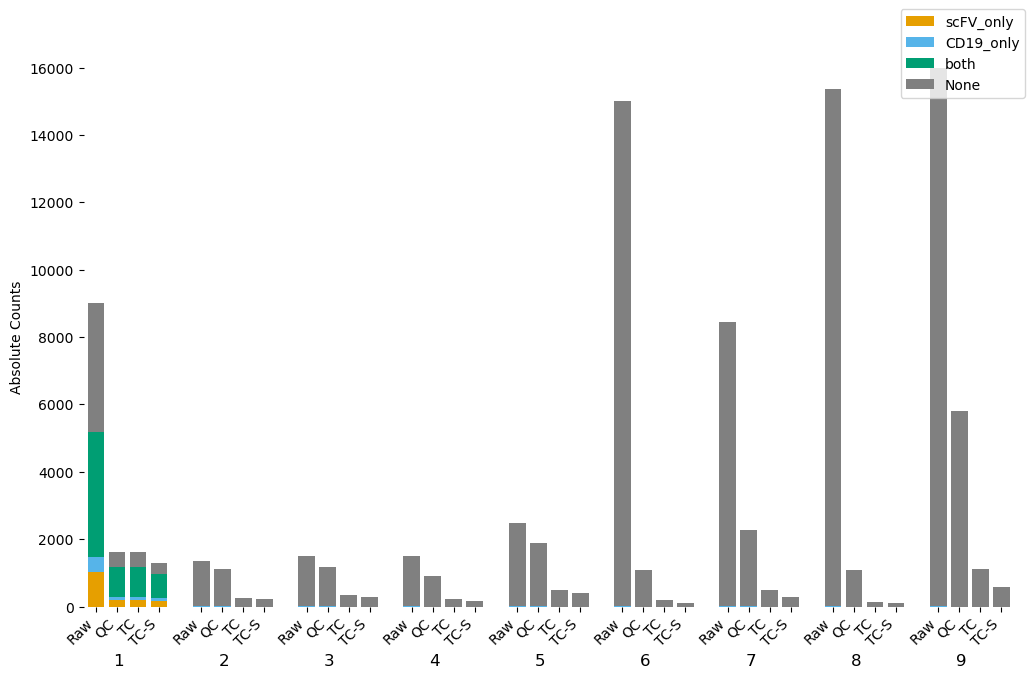

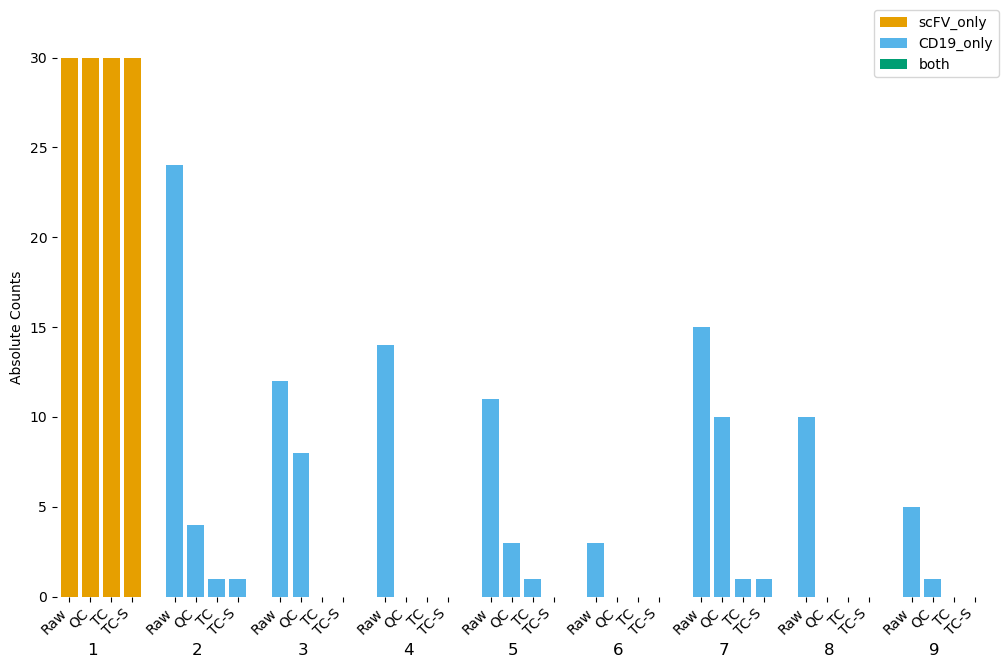

In [53]:
importlib.reload(oa)
oa.plot_receptor_countv(merged_dfs, grouping='dataset', hue='Dataset', ymax=16000, figrsize = (12,7), label=slice(2,6))
oa.plot_receptor_countv(merged_dfs, grouping='dataset', hue='Dataset', ymax=30, figrsize = (12,7))

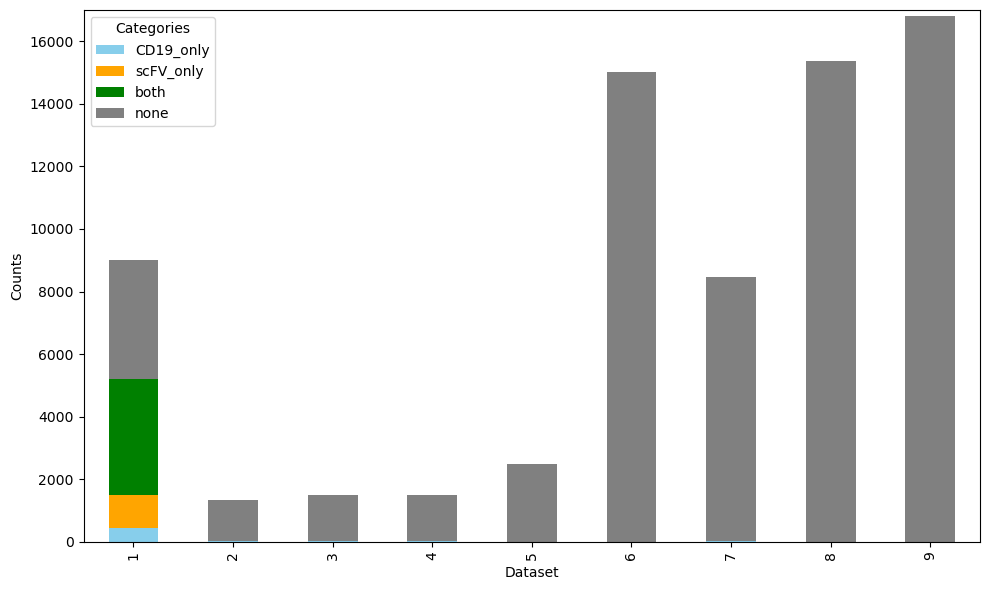

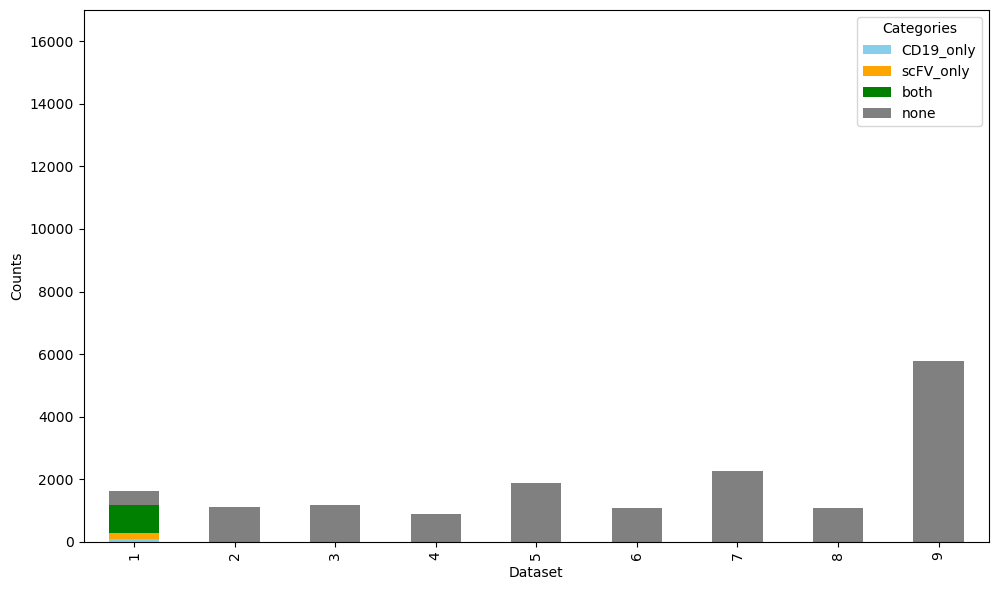

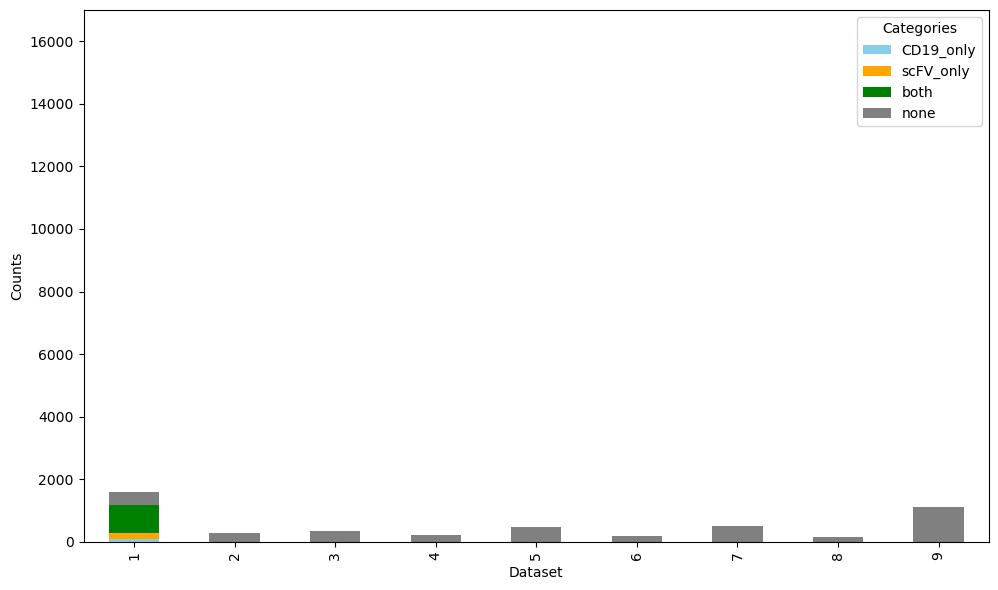

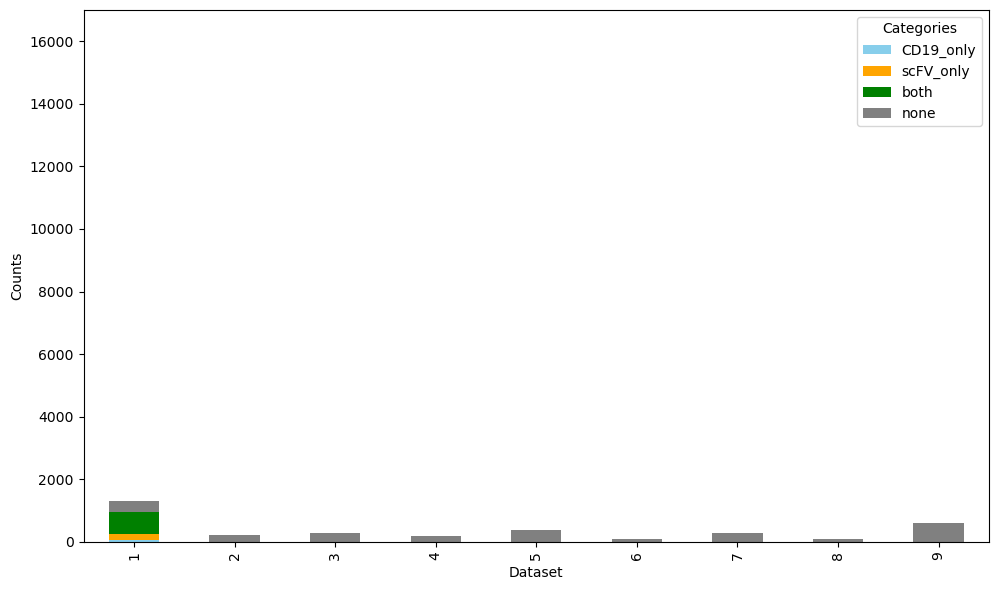

In [23]:
for i,adata in enumerate(annotated):
    datasets = np.unique(adata.obs.dataset)

    # Calculate the categories
    categories_df = ca.calculate_categories(adata.obs, datasets)

    # Plot the stacked bar plot
    ax = categories_df.plot(kind='bar', stacked=True, figsize=(10, 6), 
                            color=['skyblue', 'orange', 'green', 'gray'])
    # plt.title('Stacked Bar Plot of CD19_trunc and R11_ScFV Categories')
    plt.xlabel('Dataset')
    plt.ylabel('Counts')
    plt.legend(title='Categories')
    plt.tight_layout()
    plt.ylim(0, 17000)
    plt.show()

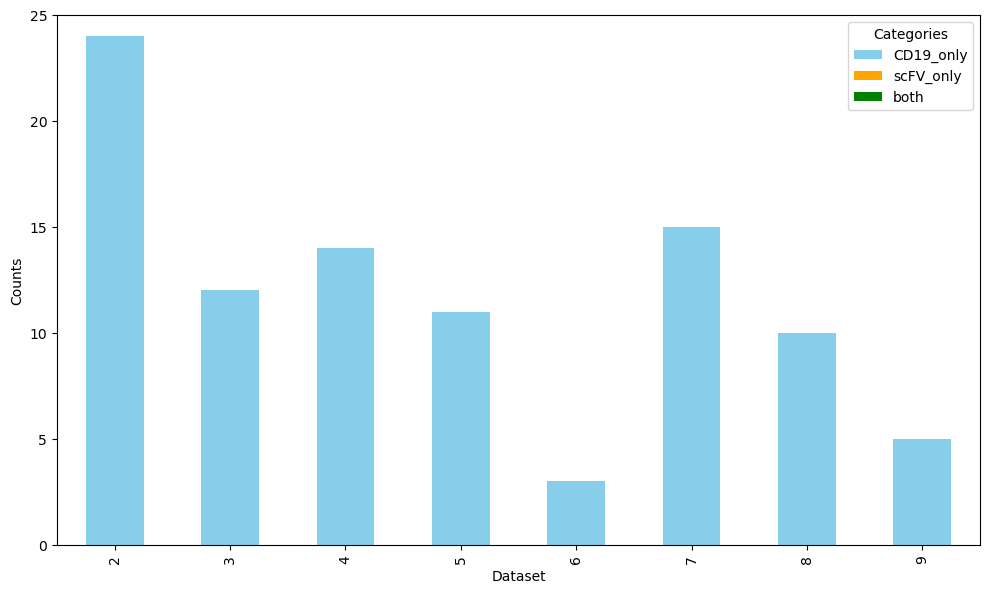

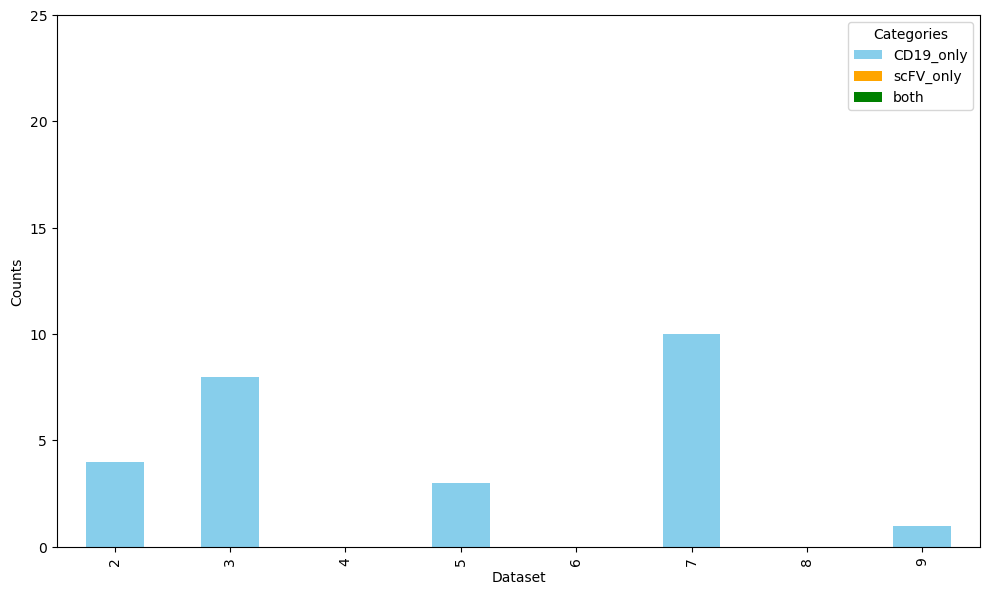

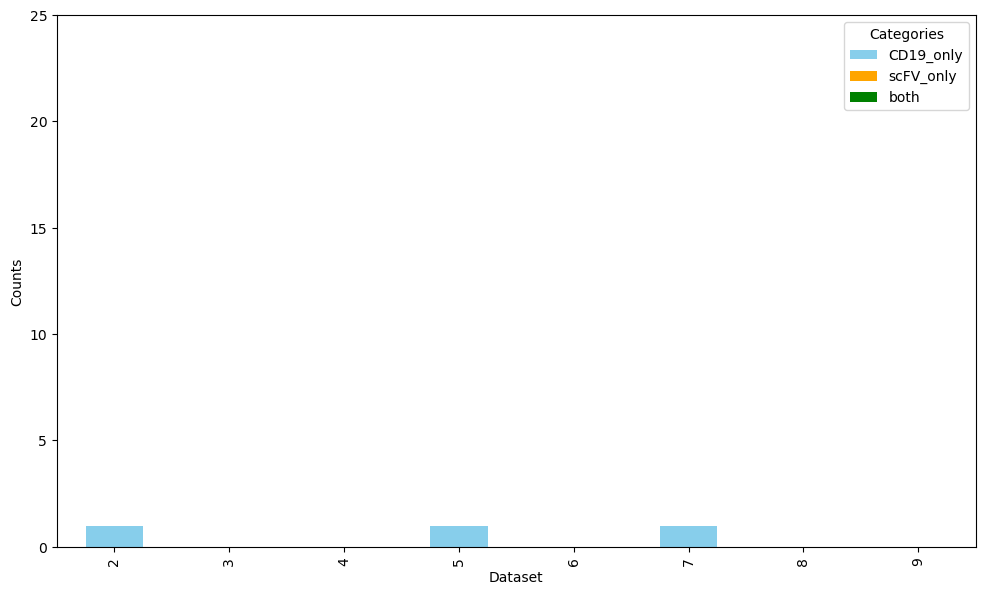

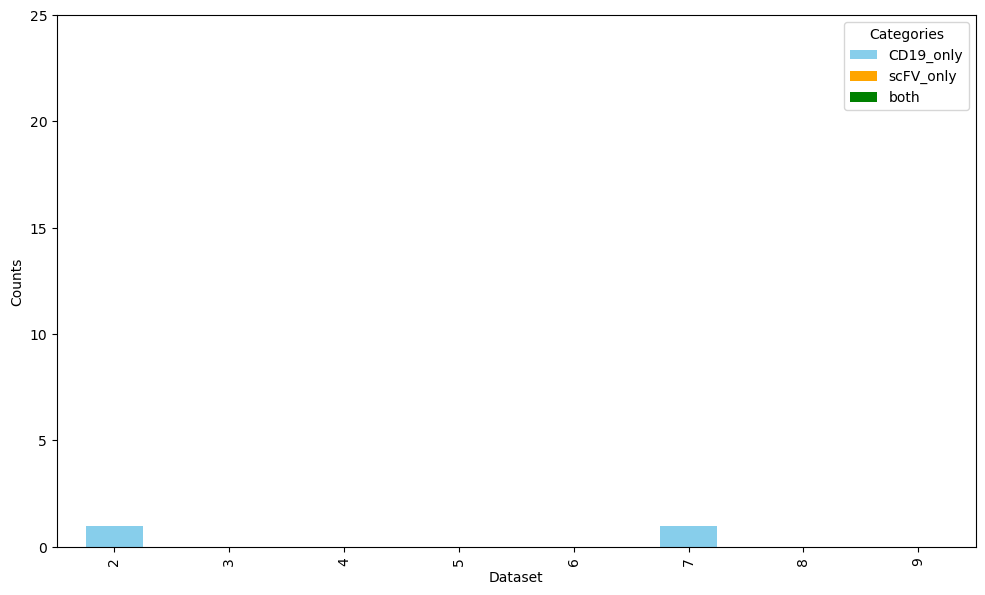

In [162]:
for i,adata in enumerate(annotated):
    datasets = np.unique(adata.obs.dataset)
    datasets = list(filter(lambda x: x != 0, datasets))

    # Calculate the categories
    categories_df = ca.calculate_categories(adata.obs, datasets)
    categories_df.drop(columns=['none'], inplace=True)
    # Plot the stacked bar plot
    ax = categories_df.plot(kind='bar', stacked=True, figsize=(10, 6), 
                            color=['skyblue', 'orange', 'green', 'gray'])
    # plt.title(f'')
    plt.xlabel('Dataset')
    plt.ylabel('Counts')
    plt.legend(title='Categories')
    plt.tight_layout()
    plt.ylim(0, 25)
    plt.show()

In [173]:
importlib.reload(ca)
df = ca.extract_receptor_count(annotated[2])
cols = ['CD19_trunc', 'scFV', 'both', 'none']
df_rel = df.copy()
df_rel[cols] = df[cols].div(df['Total'], axis=0) * 100

/home/s377963/car_t_sc/02_code/functions/functions_for_CAR_annotation.py:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_counts = df_tmp.groupby(['condition', 'day'])[['CD19_trunc', 'scFV', 'both', 'none']].sum()


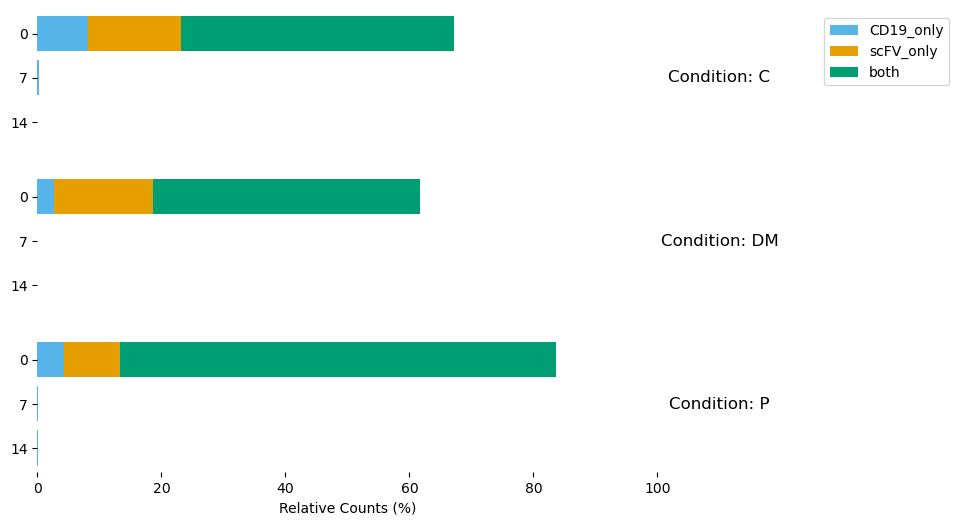

In [175]:
importlib.reload(ca)
ca.plot_receptor_count(df_rel, xmax=100, counts='Relative Counts (%)')

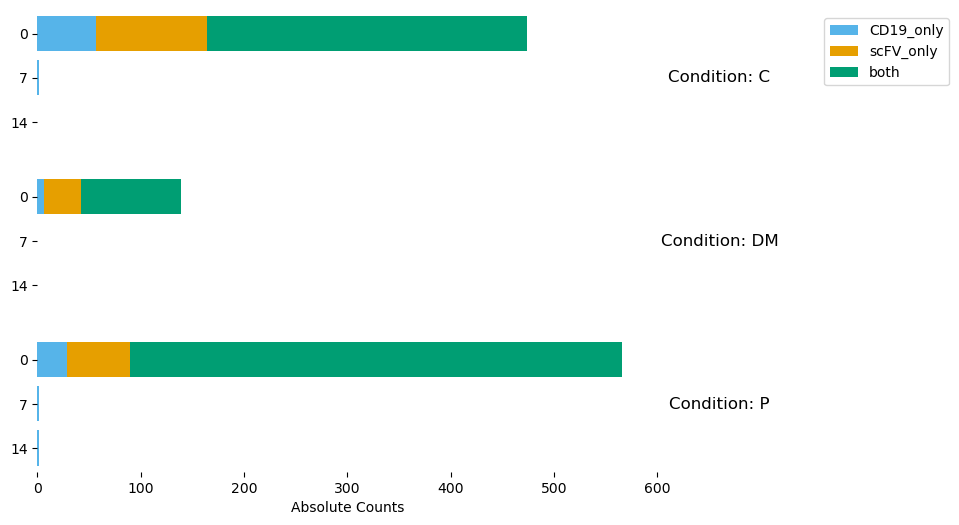

In [176]:
importlib.reload(ca)
ca.plot_receptor_count(df, xmax=600)

# 2. Workflow with the CARs annotated via Cellranger

In [177]:
#import data

CAR_adata_raw = sc.read_h5ad('./01_data/processed/merged_and_processed/CAR_genome/CAR_genome_raw_demultiplexed.h5ad') 
CAR_adata_qc = sc.read_h5ad('./01_data/processed/merged_and_processed/CAR_genome/CAR_genome_after_qc.h5ad')
CAR_adata_TIL_only = CAR_adata_qc[CAR_adata_qc.obs.Location != 'dLN']
CAR_adata_pureTC = sc.read_h5ad('./01_data/processed/merged_and_processed/CAR_genome/CAR_genome_after_qc_TIL_only_pure_TC_annotation.h5ad') 
CAR_adata_only_pureTC = CAR_adata_pureTC[CAR_adata_pureTC.obs['is.pure_Tcell'] == 'Pure']
CAR_adata_pure_TC_annotated = sc.read_h5ad('./01_data/processed/merged_and_processed/CAR_genome/CAR_genome_after_qc_TIL_only_pure_TC_annotation_non_TC_filtered_TC_subtypes_annotated.h5ad') 
CAR_adata_only_annotatedTC = CAR_adata_pure_TC_annotated[~CAR_adata_pure_TC_annotated.obs['functional.cluster'].isna()]

In [178]:
# CAR_adata_TIL_only
sum(CAR_adata_qc.obs.Location == 'dLN') #why did they kick them out again??? nearly 6K cells

5856

In [179]:
annotated = [CAR_adata_raw, CAR_adata_TIL_only, CAR_adata_only_pureTC, CAR_adata_pure_TC_annotated]

In [180]:
for adata in annotated:
    adata.obs.rename(columns={"HTO_classification": "Classification"}, inplace=True) 
    adata.obs.rename(columns={"functional.cluster": "Tcell_subtype"}, inplace=True)
    adata.obs.rename(columns={"pool": "dataset"}, inplace=True)
    rmvd_p = [int(dataset.replace("P", "")) - 1 for dataset in adata.obs['dataset']]
    adata.obs['dataset'] = rmvd_p

/tmp/ipykernel_373941/63561219.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['dataset'] = rmvd_p


In [181]:
#compute counts for all adata objects (should work based on the X matrices bein raw RNA counts)
for adata in annotated:
    adata.var['CD19_trunc'] = adata.var_names.str.startswith('CD19-trunc')
    adata.var['scFV'] = adata.var_names.str.startswith('scFV')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['CD19_trunc', 'scFV'], inplace=True, percent_top=None)
    adata.obs.rename(columns={'total_counts_scFV': 'R11_ScFV'}, inplace=True)
    adata.obs.rename(columns={'total_counts_CD19_trunc': 'CD19_trunc'}, inplace=True)


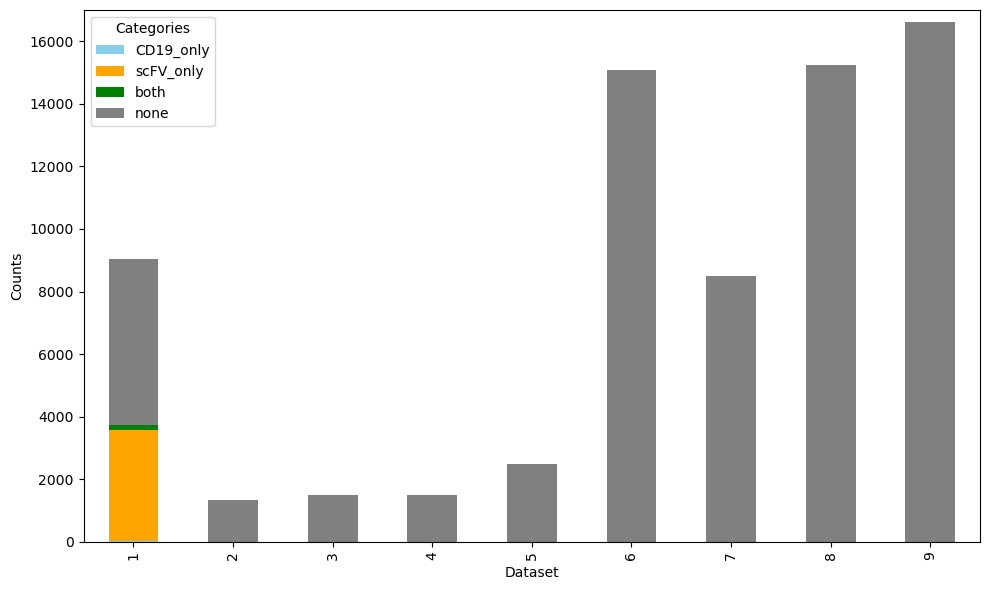

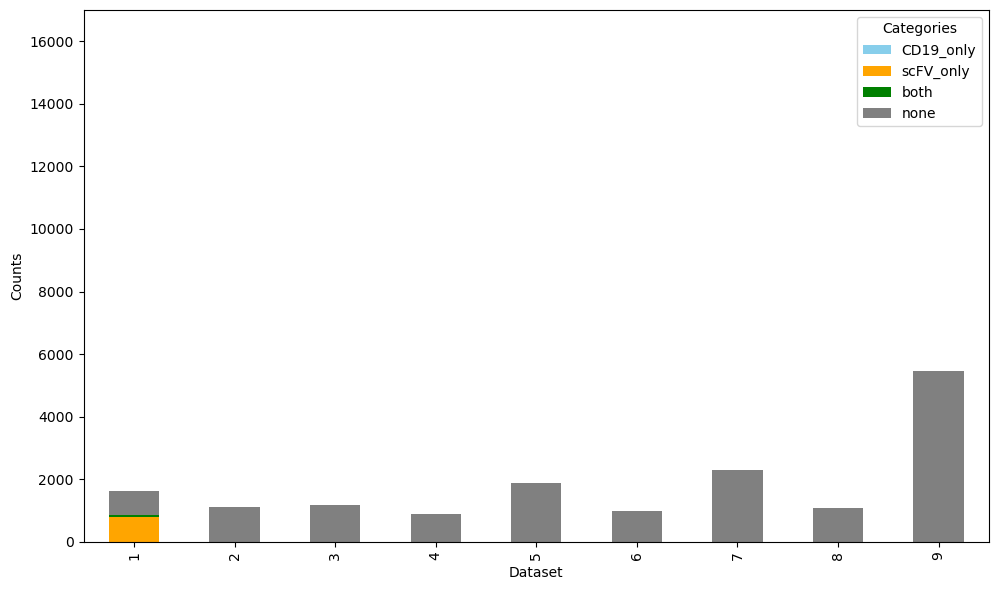

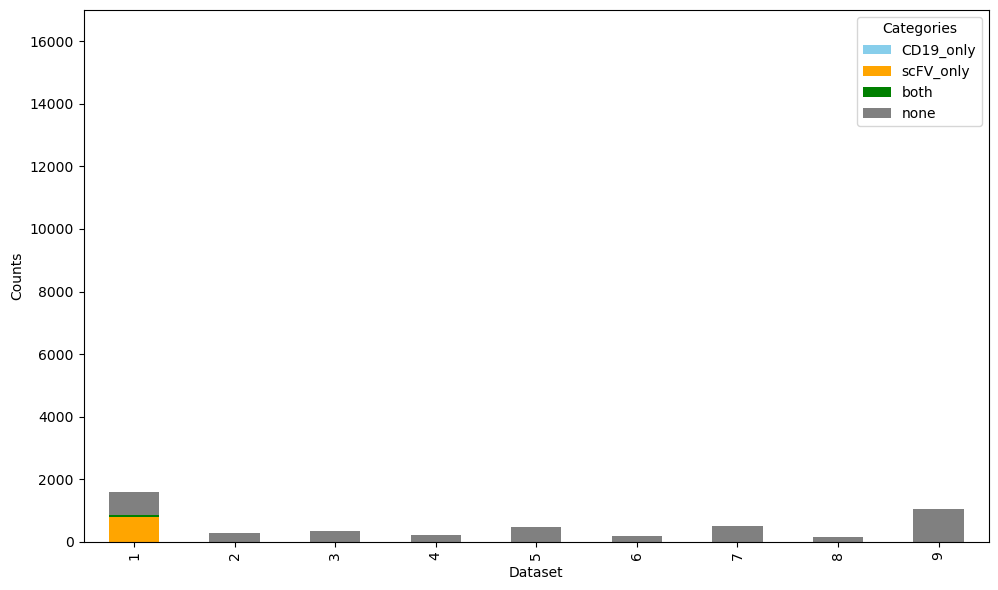

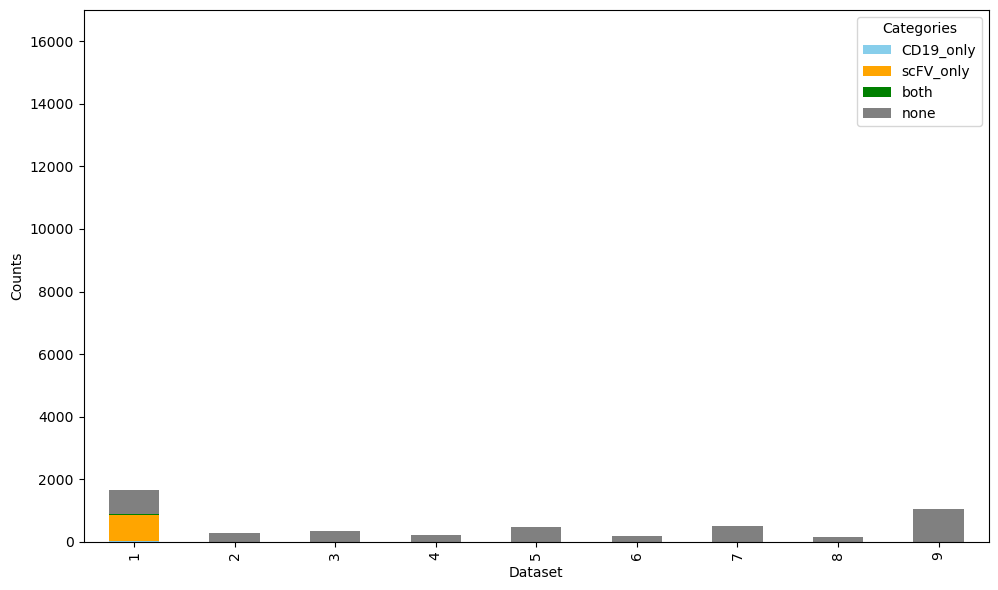

In [182]:
for i,adata in enumerate(annotated):
    datasets = np.unique(adata.obs.dataset)

    # Calculate the categories
    categories_df = ca.calculate_categories(adata.obs, datasets)

    # Plot the stacked bar plot
    ax = categories_df.plot(kind='bar', stacked=True, figsize=(10, 6), 
                            color=['skyblue', 'orange', 'green', 'gray'])
    # plt.title('Stacked Bar Plot of CD19_trunc and R11_ScFV Categories')
    plt.xlabel('Dataset')
    plt.ylabel('Counts')
    plt.legend(title='Categories')
    plt.tight_layout()
    plt.ylim(0, 17000)
    plt.show()

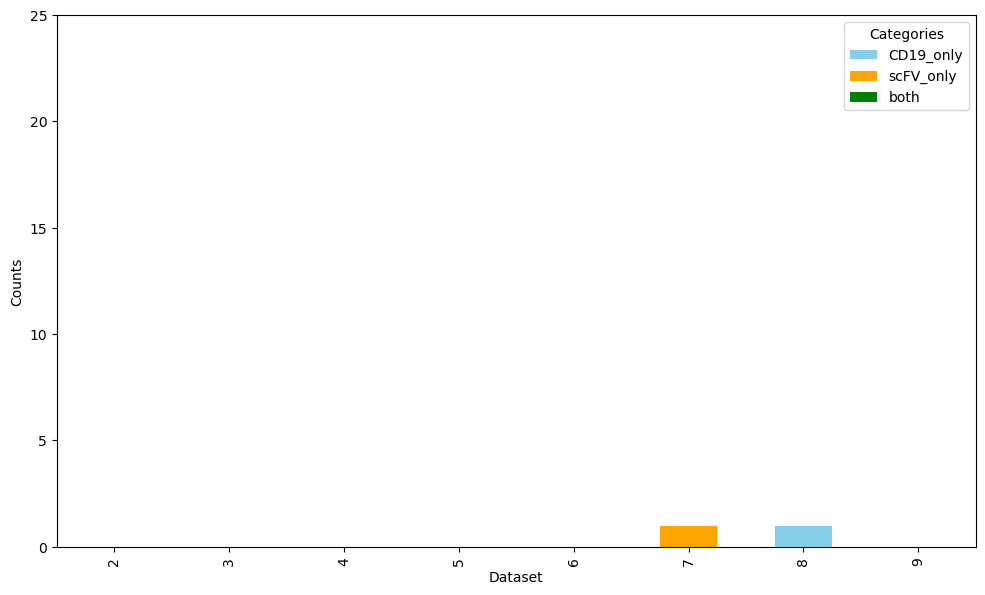

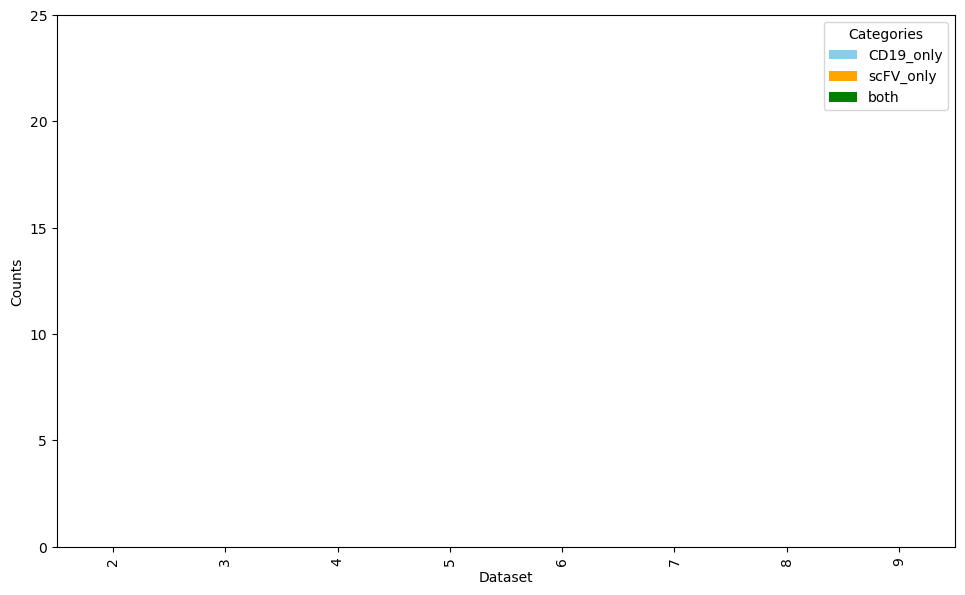

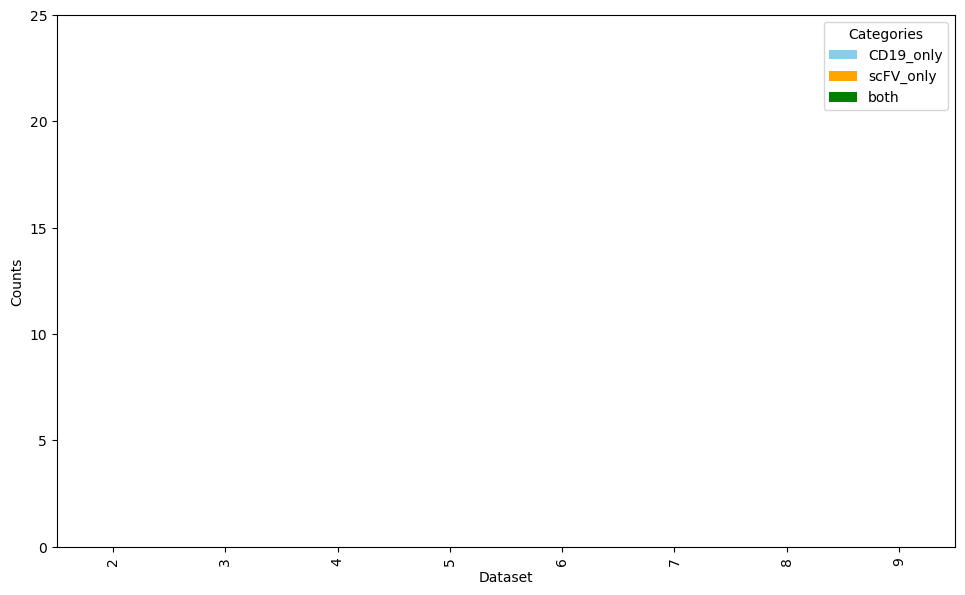

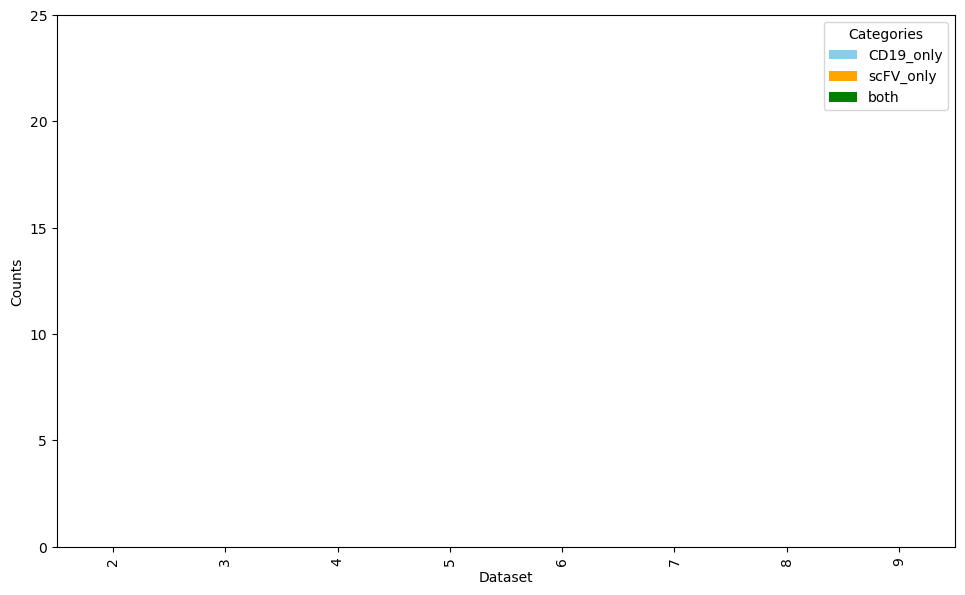

In [183]:
for i,adata in enumerate(annotated):
    datasets = np.unique(adata.obs.dataset)
    datasets = list(filter(lambda x: x != 0, datasets))

    # Calculate the categories
    categories_df = ca.calculate_categories(adata.obs, datasets)
    categories_df.drop(columns=['none'], inplace=True)
    # Plot the stacked bar plot
    ax = categories_df.plot(kind='bar', stacked=True, figsize=(10, 6), 
                            color=['skyblue', 'orange', 'green', 'gray'])
    # plt.title(f'')
    plt.xlabel('Dataset')
    plt.ylabel('Counts')
    plt.legend(title='Categories')
    plt.tight_layout()
    plt.ylim(0, 25)
    plt.show()

In [184]:
importlib.reload(ca)
df = ca.extract_receptor_count(annotated[2])
cols = ['CD19_trunc', 'scFV', 'both', 'none']
df_rel = df.copy()
df_rel[cols] = df[cols].div(df['Total'], axis=0) * 100

/home/s377963/car_t_sc/02_code/functions/functions_for_CAR_annotation.py:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_counts = df_tmp.groupby(['condition', 'day'])[['CD19_trunc', 'scFV', 'both', 'none']].sum()


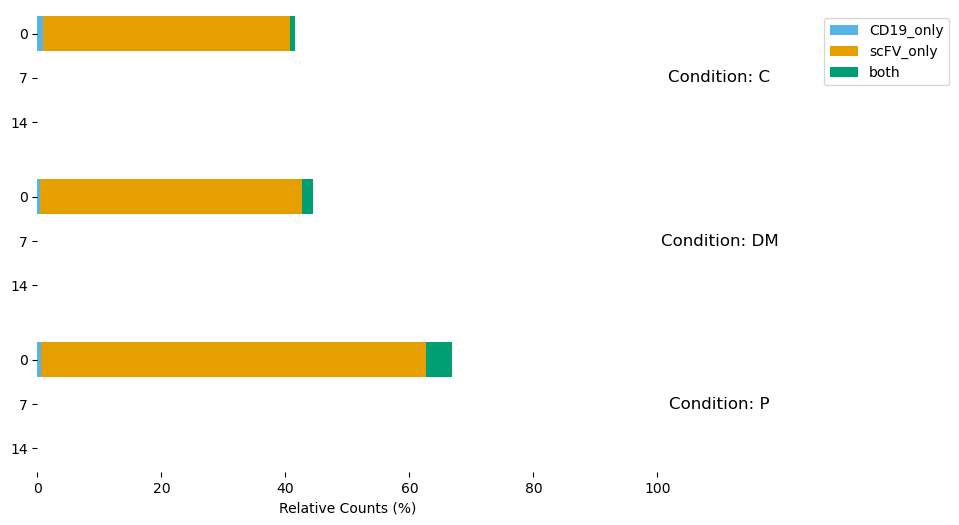

In [185]:
importlib.reload(ca)
ca.plot_receptor_count(df_rel, xmax=100, counts='Relative Counts (%)')

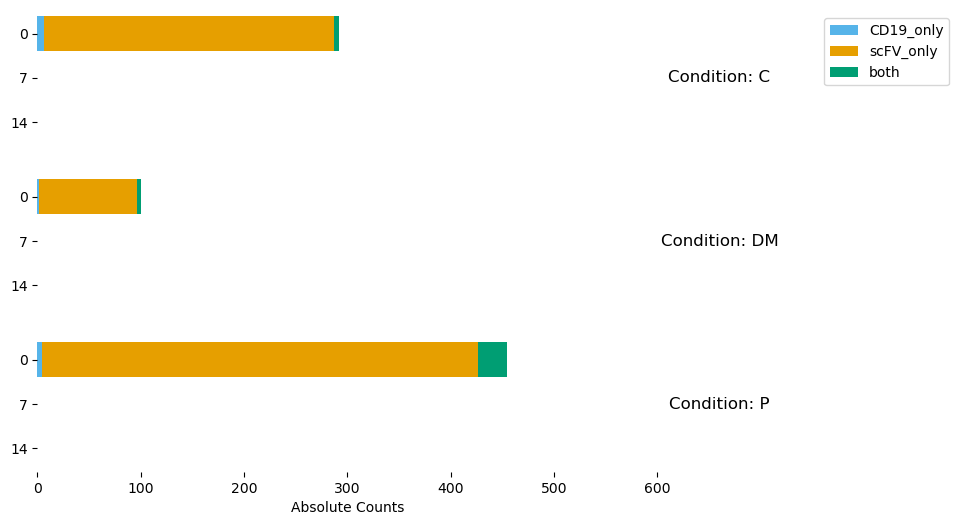

In [186]:
importlib.reload(ca)
ca.plot_receptor_count(df, xmax=600)